In [1]:

import MetaTrader5 as mt5
import pandas as pd
import datetime
import mplfinance as mpf
import pandas_ta as pta
import numpy as np
from ta.momentum import RSIIndicator


if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()

In [2]:
symbol = "ETHUSD"
data = pd.DataFrame(mt5.copy_rates_from_pos(
            symbol,
            mt5.TIMEFRAME_M5,
            0,
            100
        ))

data["time"] = pd.to_datetime(data["time"], unit="s")

# convert to local time
seven_hours = datetime.timedelta(hours=7)
data["Date"] = data["time"] - seven_hours
data["local_time"] = data["time"] - seven_hours


# create index
data = data.set_index("Date")
data.sort_index(ascending=False, inplace=True)

# sort ascending for chart
chart_data = data.sort_index( ascending=True, inplace=False)


In [41]:
data.columns

Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread',
       'real_volume', 'local_time'],
      dtype='object')

In [195]:
# data is sorted with most recent time first



def check_cdl_engulfing():
    for index in range(len(data)-1):
        print(index)
        current_cndl = data.iloc[index]
        previous_cndl = data.iloc[index+1]
        if current_cndl.open <= previous_cndl.close and current_cndl.close >= previous_cndl.open:
            data.at[current_cndl.local_time, "cdl_engulfing"] = 100   # it would be better if we can use the index, but unable to do so
        else:
            data.at[current_cndl.local_time, "cdl_engulfing"] = 0   # it would be better if we can use the index, but unable to do so
    



In [332]:
data = data.between_time('10:15', '12:55')

In [6]:
data["cdl_size"] = data["close"] - data["open"]
data["cdl_up"] = np.where(data["cdl_size"] > 0, True, False)



# count number of down days before the current candle 
data["prev_3cdl_down_trend"] = np.where( 
                            (data.shift(-1)["cdl_up"] == False) &
                            (data.shift(-2)["cdl_up"] == False) &
                            (data.shift(-3)["cdl_up"] == False),
                         True, False
                         )

data["prev_4cdl_down_trend"] = np.where( 
                            (data.shift(-1)["cdl_up"] == False) &
                            (data.shift(-2)["cdl_up"] == False) &
                            (data.shift(-3)["cdl_up"] == False) &
                            (data.shift(-4)["cdl_up"] == False),
                         True, False
                         )

data["cdl_bullish_engulfing"] = np.where( (data["open"] <= data.shift(-1)["close"]) &
                                             (data["close"] >= data.shift(-1)["open"]) & 
                                             ((data["cdl_up"]) & (data.shift(-1)["cdl_up"] == False)) &
                                             (data["prev_4cdl_down_trend"]),
                                         True, False
                                        )


     
   



In [ ]:
result = data[["cdl_bullish_engulfing", "open", "close", "cdl_size", "cdl_up", "prev_3cdl_down_trend",  "prev_4cdl_down_trend"]]
result

In [15]:
# bearish engulfing pattern
data["prev_3cdl_up_trend"] = np.where( 
                            (data.shift(-1)["cdl_up"]) &
                            (data.shift(-2)["cdl_up"]) &
                            (data.shift(-3)["cdl_up"]),
                         True, False
                         )

data["prev_4cdl_up_trend"] = np.where( 
                            (data.shift(-1)["cdl_up"]) &
                            (data.shift(-2)["cdl_up"]) &
                            (data.shift(-3)["cdl_up"]) &
                            (data.shift(-4)["cdl_up"]),
                         True, False
                         )

# change to bearish
data["cdl_bearish_engulfing"] = np.where( (data["close"] <= data.shift(-1)["open"]) &
                                             (data["open"] >= data.shift(-1)["close"]) & 
                                             ((data["cdl_up"] == False) & (data.shift(-1)["cdl_up"] == True)) &
                                             (data["prev_4cdl_up_trend"]),
                                         True, False
                                        )

In [17]:
result = data[["cdl_bearish_engulfing", "open", "close", "cdl_size", "cdl_up", "prev_3cdl_up_trend",  "prev_4cdl_up_trend"]]

result

,cdl_bearish_engulfing,open,close,cdl_size,cdl_up,prev_3cdl_up_trend,prev_4cdl_up_trend
Date,,,,,,,
2023-12-16 19:20:00,False,2232.06,2231.90,-0.16,False,False,False
2023-12-16 19:15:00,False,2232.37,2232.06,-0.31,False,False,False
2023-12-16 19:10:00,False,2230.61,2232.37,1.76,True,False,False
2023-12-16 19:05:00,False,2231.62,2230.61,-1.01,False,True,True
2023-12-16 19:00:00,False,2228.91,2231.62,2.71,True,True,False
...,...,...,...,...,...,...,...
2023-12-16 11:15:00,False,2252.16,2254.72,2.56,True,False,False
2023-12-16 11:10:00,False,2254.38,2252.16,-2.22,False,False,False
2023-12-16 11:05:00,False,2256.94,2254.38,-2.56,False,False,False


In [401]:
x = result.query("cdl_bullish_engulfing == True")
x

,cdl_bullish_engulfing,open,close,cdl_size,cdl_up,prev_3cdl_down_trend,prev_4cdl_down_trend
Date,,,,,,,
2023-12-16 15:55:00,True,2235.51,2238.06,2.55,True,True,True


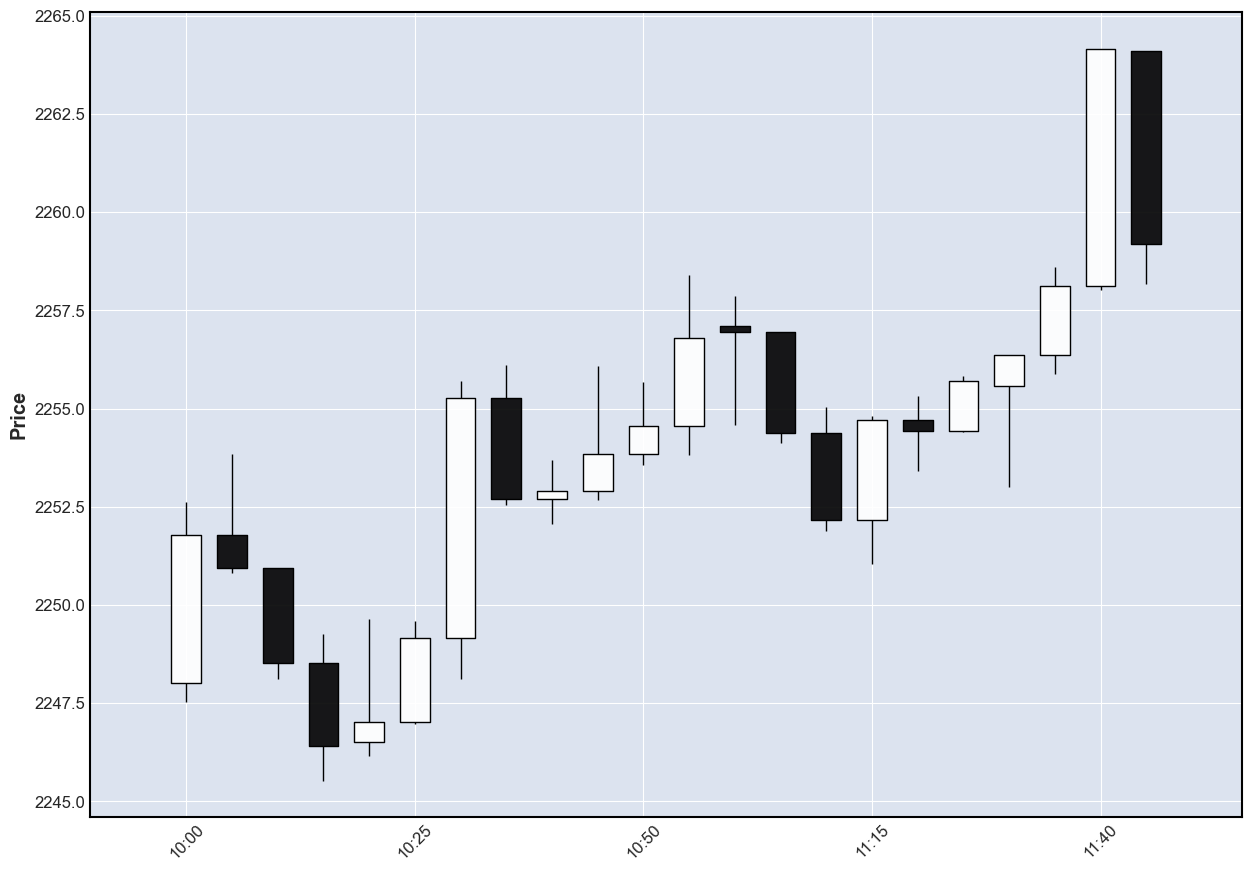

In [410]:


# let's isolate a case where we want to open a trade
focus_data =  chart_data.between_time('10:00', '11:45')

mpf.plot(focus_data, type="candle", figscale=2.0)



In [248]:


def set_cndl_up_or_down(row):
    if row["cndl_body_size"] > 0:
        return "up"
    else:
        return "down"




In [249]:

focus_data["cndl_body_size"] = focus_data["Close"] - focus_data["Open"]
focus_data["cndl_direction"] = focus_data.apply(set_cndl_up_or_down, axis=1)
focus_data

C:\Users\micha\AppData\Local\Temp\ipykernel_16832\2222612621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_data["cndl_body_size"] = focus_data["Close"] - focus_data["Open"]
C:\Users\micha\AppData\Local\Temp\ipykernel_16832\2222612621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_data["cndl_direction"] = focus_data.apply(set_cndl_up_or_down, axis=1)


,time,Open,High,Low,Close,Volume,spread,real_volume,cndl_body_size,cndl_direction
Date,,,,,,,,,,
2023-12-13 05:00:00,2023-12-13 12:00:00,2178.71,2179.19,2176.79,2178.76,438,146,0,0.05,up
2023-12-13 05:05:00,2023-12-13 12:05:00,2178.76,2180.24,2178.39,2180.09,245,146,0,1.33,up
2023-12-13 05:10:00,2023-12-13 12:10:00,2180.09,2181.52,2179.08,2181.25,232,146,0,1.16,up
2023-12-13 05:15:00,2023-12-13 12:15:00,2181.25,2181.92,2178.69,2178.78,320,146,0,-2.47,down
2023-12-13 05:20:00,2023-12-13 12:20:00,2178.78,2179.37,2175.55,2176.35,293,146,0,-2.43,down
2023-12-13 05:25:00,2023-12-13 12:25:00,2176.35,2176.47,2171.28,2172.80,240,146,0,-3.55,down
2023-12-13 05:30:00,2023-12-13 12:30:00,2172.80,2173.82,2169.80,2172.74,283,146,0,-0.06,down
2023-12-13 05:35:00,2023-12-13 12:35:00,2172.74,2178.69,2171.93,2174.75,466,146,0,2.01,up
2023-12-13 05:40:00,2023-12-13 12:40:00,2174.75,2175.83,2173.54,2174.44,220,146,0,-0.31,down


In [250]:
# is the last bar a bullish engulfing candle
current_bar = focus_data.iloc[-1]
previous_bar = focus_data.iloc[-2]

print(current_bar, previous_bar)

# count number of down bars out of last 7
#number_of_down_bars = len(data.tail(8).query("cndl_direction == 'down'"))


time              2023-12-13 14:05:00
Open                          2171.88
High                          2174.27
Low                            2169.7
Close                         2174.27
Volume                            517
spread                            146
real_volume                         0
cndl_body_size                   2.39
cndl_direction                     up
Name: 2023-12-13 07:05:00, dtype: object time              2023-12-13 14:00:00
Open                          2172.32
High                          2174.22
Low                           2171.43
Close                         2171.88
Volume                            582
spread                            146
real_volume                         0
cndl_body_size                  -0.44
cndl_direction                   down
Name: 2023-12-13 07:00:00, dtype: object


In [269]:

print(current_bar.Open, previous_bar.Close)


# lets make sure we were in an up or down trend before the change in direction
focus_data.sort_index( ascending=False, inplace=True)
down_days = len(focus_data.iloc[1:8].query("cndl_direction == 'down'"))
up_days = len(focus_data.iloc[1:8].query("cndl_direction == 'up'"))

is_down_trend = (
    True if down_days > 5
    else False
)

is_up_trend = (
    True if up_days > 4
    else False
)

# bullish check
is_covering_previous_candle_bullish = (
    True if current_bar.Close > previous_bar.Open and
    current_bar.Open <= previous_bar.Close
    else False
)

# bearish check
is_covering_previous_candle_bearish = (
    True if current_bar.Close < previous_bar.Open and
    current_bar.Open <= previous_bar.Close
    else False
)

is_bullish_engulfing = (
    True if current_bar.cndl_direction == "up" and previous_bar.cndl_direction == "down" and 
    abs(current_bar.cndl_body_size) > abs(previous_bar.cndl_body_size) and
    current_bar.Close > previous_bar.Open and
    current_bar.Open <= previous_bar.Close and
    down_days >= 4
    else False
)

is_bearish_engulfing = (
    True if current_bar.cndl_direction == "down" and previous_bar.cndl_direction == "up" and
    abs(current_bar.cndl_body_size) > abs(previous_bar.cndl_body_size) and 
    current_bar.Close < previous_bar.Open and
    current_bar.Open <= previous_bar.Close and
    up_days >= 4
    else False
)


if is_bullish_engulfing:
    print("Bullish Engulfing")
else:
    print("Bearish Engulfing")

2171.88 2171.88
Bullish Engulfing


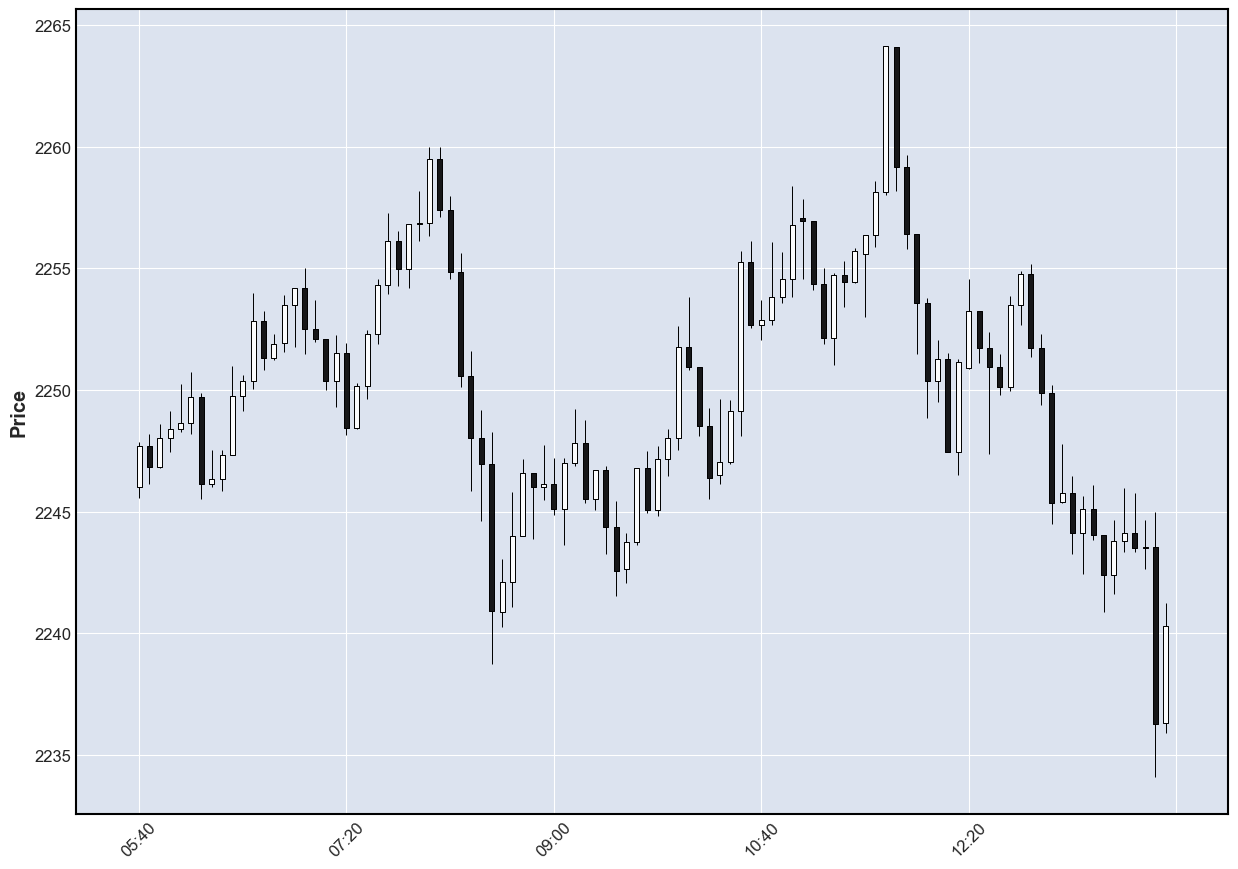

In [248]:

# upper case column names because charting library requires it 
chart_data = chart_data.rename(columns={"open": "Open", "close": "Close", "high": "High", "low": "Low", "tick_volume": "Volume"})

mpf.plot(chart_data, type="candle", figscale=2.0)
